Importing Walid's calculation of the scattering parameters of the combination of coaxial adapter and impedance transformer

In [1]:
%matplotlib notebook

In [2]:
from scipy.io.matlab import loadmat
import skrf as rf
import numpy as np
from numpy import sqrt, abs, pi, exp
import matplotlib.pyplot as plt
rf.stylely('skrf_wide.mplstyle')

C:\Users\JH218595\AppData\Local\Continuum\Anaconda3\lib\site-packages\matplotlib\style\core.py:112: UserWarning: Style includes a parameter, 'interactive', that is not related to style.  Ignoring
  _apply_style(rc)


# S-parameter of the manually matched IC3 antenna

Low level RF measurements before the IC3 antenna was inserted in TITAN

## Left side


In [3]:
left1 = rf.Network('Sparameters/Gauche_Match55.5MHz_solution1.s4p', f_unit='MHz')
left2 = rf.Network('Sparameters/Gauche_Match55.5MHz_solution2.s4p', f_unit='MHz')
right1 = rf.Network('Sparameters/Droit_Match55.5MHz_solution1.s4p', f_unit='MHz')
right2 = rf.Network('Sparameters/Droit_Match55.5MHz_solution2.s4p', f_unit='MHz')

<IPython.core.display.Javascript object>


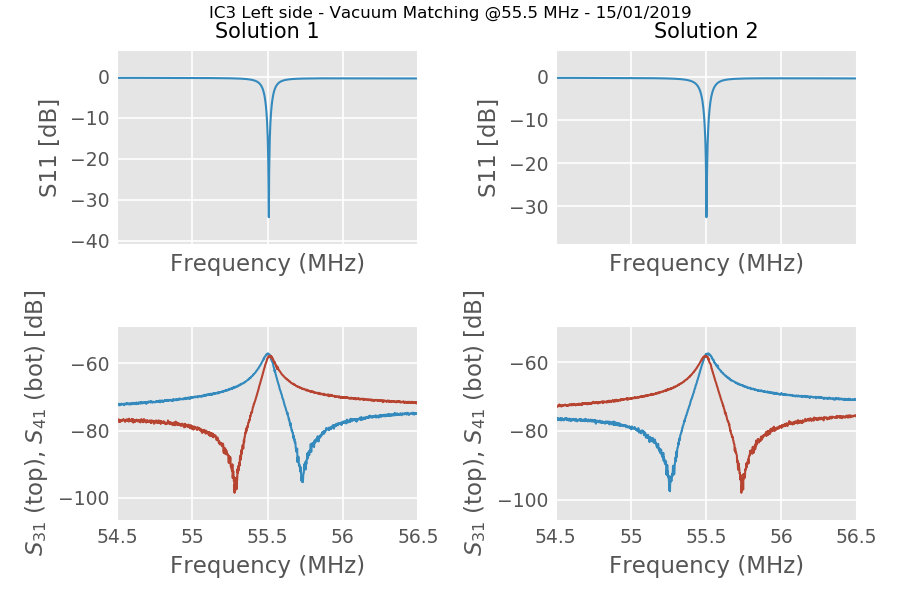

In [4]:
fig, axes = plt.subplots(2, 2, sharex=True)
# Left side - solution 1
left1.plot_s_db(m=0, n=0, ax=axes[0,0], show_legend=False, y_label='S11 [dB]')
left1.plot_s_db(m=2, n=0, ax=axes[1,0], show_legend=False)
left1.plot_s_db(m=3, n=0, ax=axes[1,0], show_legend=False, y_label='$S_{31}$ (top), $S_{41}$ (bot) [dB]')
# Left side - solution 2
left2.plot_s_db(m=0, n=0, ax=axes[0,1], show_legend=False, y_label='S11 [dB]')
left2.plot_s_db(m=2, n=0, ax=axes[1,1], show_legend=False)
left2.plot_s_db(m=3, n=0, ax=axes[1,1], show_legend=False, y_label='$S_{31}$ (top), $S_{41}$ (bot) [dB]')


fig.suptitle('IC3 Left side - Vacuum Matching @55.5 MHz - 15/01/2019', fontsize=8, y=0.99)
axes[0,0].set_title('Solution 1', fontsize=10)
axes[0,1].set_title('Solution 2', fontsize=10)
fig.tight_layout()
fig.savefig('IC3_Left_Matched55.5MHz.png', dpi=600)


## Right side

<IPython.core.display.Javascript object>


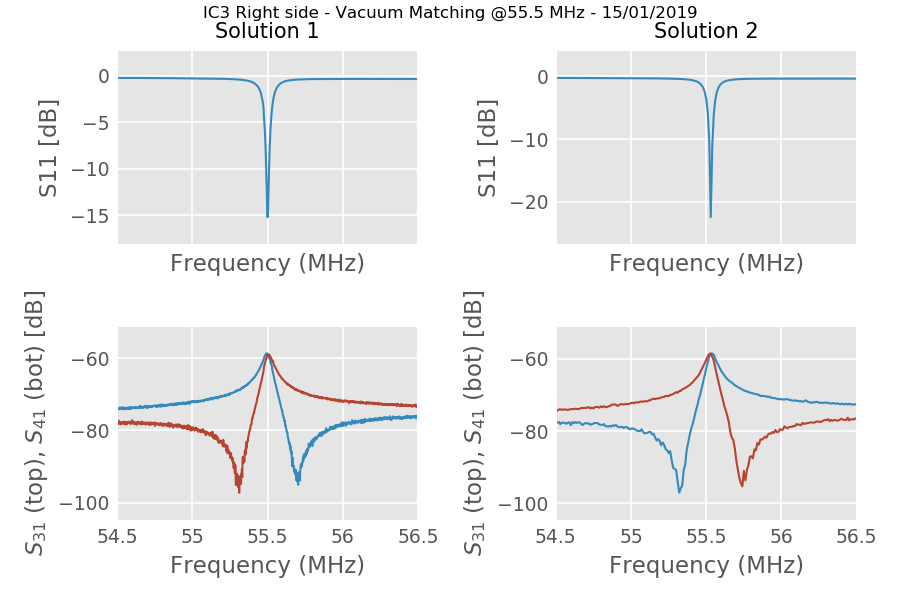

In [5]:
fig, axes = plt.subplots(2, 2, sharex=True)
# Right side - solution 1
right1.plot_s_db(m=1, n=1, ax=axes[0,0], show_legend=False, y_label='S11 [dB]')
right1.plot_s_db(m=2, n=1, ax=axes[1,0], show_legend=False)
right1.plot_s_db(m=3, n=1, ax=axes[1,0], show_legend=False, y_label='$S_{31}$ (top), $S_{41}$ (bot) [dB]')
# Left side - solution 2
right2['54.5-56.5'].plot_s_db(m=1, n=1, ax=axes[0,1], show_legend=False, y_label='S11 [dB]')
right2['54.5-56.5'].plot_s_db(m=2, n=1, ax=axes[1,1], show_legend=False)
right2['54.5-56.5'].plot_s_db(m=3, n=1, ax=axes[1,1], show_legend=False, y_label='$S_{31}$ (top), $S_{41}$ (bot) [dB]')

fig.suptitle('IC3 Right side - Vacuum Matching @55.5 MHz - 15/01/2019', fontsize=8, y=0.99)
axes[0,0].set_title('Solution 1', fontsize=10)
axes[0,1].set_title('Solution 2', fontsize=10)
fig.tight_layout()
fig.savefig('IC3_Right_Matched55.5MHz.png', dpi=600)


# Low level RF measurements in TITAN

## Left side

In [6]:
left_sol1_1 = rf.Network('Sparameters/IC3_Left_55p5MHz_TITAN_1.s4p', f_unit='MHz')
left_sol1_2 = rf.Network('Sparameters/IC3_Left_55p5MHz_TITAN_2.s4p', f_unit='MHz')
left_sol2_1 = rf.Network('Sparameters/IC3_Left_55p5MHz_TITAN_3.s4p', f_unit='MHz')
left_sol2_2 = rf.Network('Sparameters/IC3_Left_55p5MHz_TITAN_4.s4p', f_unit='MHz')

<IPython.core.display.Javascript object>


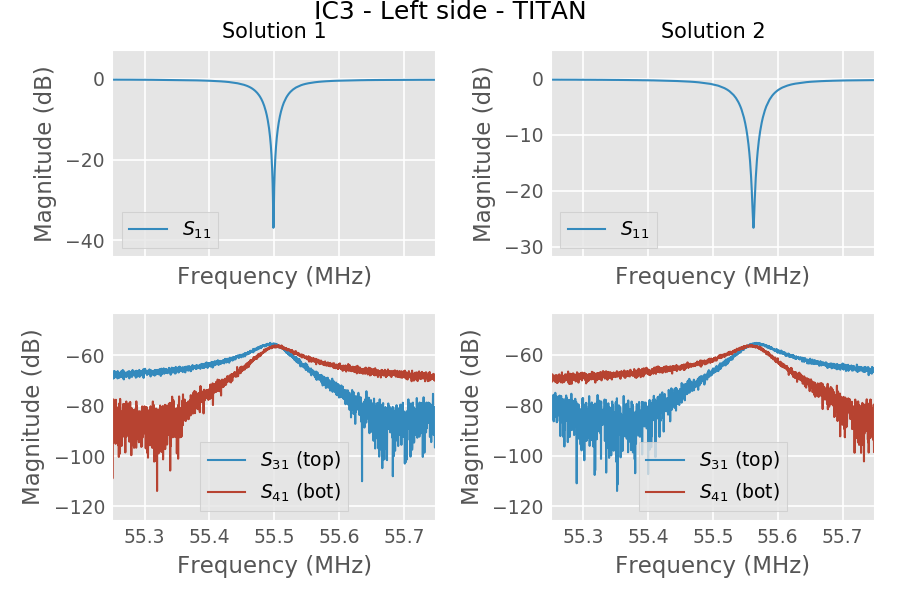

In [7]:
fig, axes = plt.subplots(2, 2, sharex=True)
left_sol1_2.plot_s_db(ax=axes[0,0], m=0, n=0, label='$S_{11}$') # S11 solution 1
left_sol2_2.plot_s_db(ax=axes[0,1], m=0, n=0, label='$S_{11}$') # S11 solution 2

left_sol1_2.plot_s_db(ax=axes[1,0], m=2, n=0, label='$S_{31}$ (top)') # S31 solution 1
left_sol1_2.plot_s_db(ax=axes[1,0], m=3, n=0, label='$S_{41}$ (bot)') # S41 solution 1

left_sol2_2.plot_s_db(ax=axes[1,1], m=2, n=0, label='$S_{31}$ (top)') # S31 solution 2
left_sol2_2.plot_s_db(ax=axes[1,1], m=3, n=0, label='$S_{41}$ (bot)') # S41 solution 2
axes[0,0].set_title('Solution 1', fontsize=10)
axes[0,1].set_title('Solution 2', fontsize=10)


fig.suptitle('IC3 - Left side - TITAN', y=1)
fig.tight_layout()
fig.savefig('IC3_Left_Matched55.5MHz_TITAN.png', dpi=600)


## Right side 

In [8]:
right_sol1_1 = rf.Network('Sparameters/IC3_Right_55p5MHz_TITAN_1.s4p', f_unit='MHz')
right_sol1_2 = rf.Network('Sparameters/IC3_Right_55p5MHz_TITAN_2.s4p', f_unit='MHz')
right_sol2_1 = rf.Network('Sparameters/IC3_Right_55p5MHz_TITAN_3.s4p', f_unit='MHz')
right_sol2_2 = rf.Network('Sparameters/IC3_Right_55p5MHz_TITAN_4.s4p', f_unit='MHz')

<IPython.core.display.Javascript object>


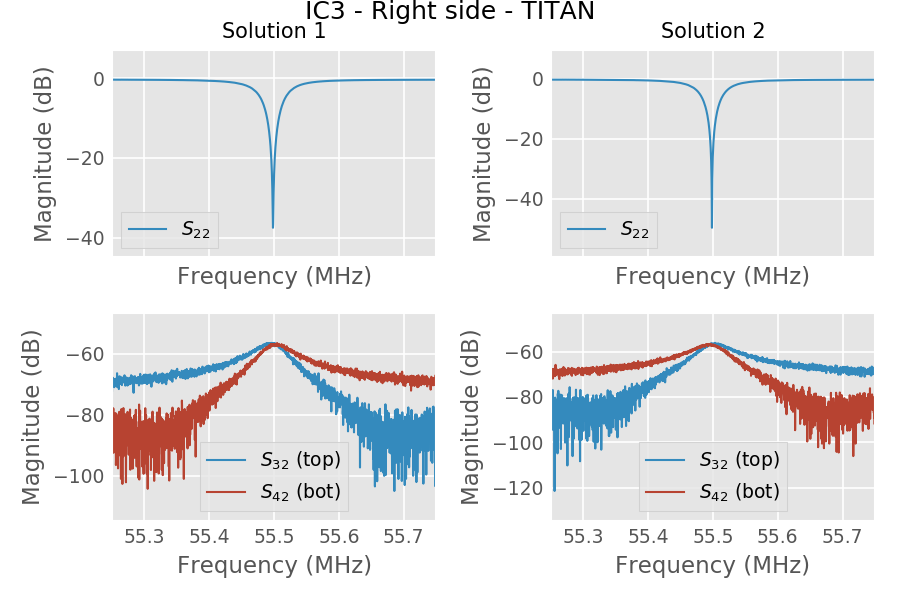

In [9]:
fig, axes = plt.subplots(2, 2, sharex=True)
right_sol1_2.plot_s_db(ax=axes[0,0], m=1, n=1, label='$S_{22}$') # S11 solution 1
right_sol2_2.plot_s_db(ax=axes[0,1], m=1, n=1, label='$S_{22}$') # S11 solution 2

right_sol1_2.plot_s_db(ax=axes[1,0], m=2, n=1, label='$S_{32}$ (top)') # S31 solution 1
right_sol1_2.plot_s_db(ax=axes[1,0], m=3, n=1, label='$S_{42}$ (bot)') # S41 solution 1

right_sol2_2.plot_s_db(ax=axes[1,1], m=2, n=1, label='$S_{32}$ (top)') # S31 solution 2
right_sol2_2.plot_s_db(ax=axes[1,1], m=3, n=1, label='$S_{42}$ (bot)') # S41 solution 2
axes[0,0].set_title('Solution 1', fontsize=10)
axes[0,1].set_title('Solution 2', fontsize=10)


fig.suptitle('IC3 - Right side - TITAN', y=1)
fig.tight_layout()
fig.savefig('IC3_Right_Matched55.5MHz_TITAN.png', dpi=600)

# Extracting the Coupling Resistance

## Left side in TITAN

In [10]:
left = rf.Network('Sparameters/IC3_Left_55p5MHz_TITAN_2.s4p', f_unit='MHz')
left

4-Port Network: 'IC3_Left_55p5MHz_TITAN_2',  55.25-55.75 MHz, 2001 pts, z0=[50.+0.j 50.+0.j 50.+0.j 50.+0.j]

<IPython.core.display.Javascript object>


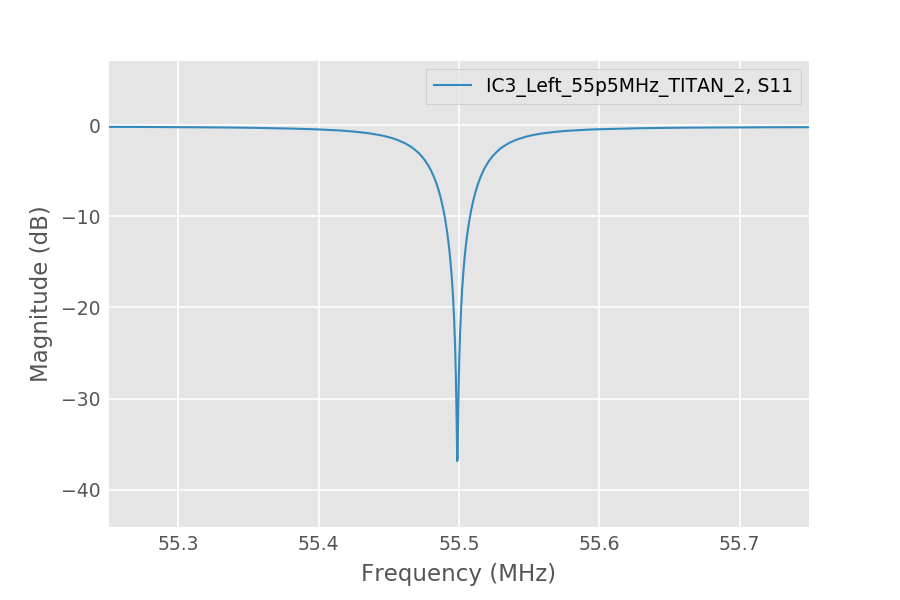

In [11]:
fig, ax = plt.subplots()
left.plot_s_db(m=0, n=0, ax=ax)

In [12]:
# excitation vector :
A = np.r_[1, 0, 0, 0]
# antenna response :
B = left.s @ A
B.shape

(2001, 4)

In [13]:
def calculate_Xs(f_MHz):
    """
    Xs from interpolation
    """
    p1Xs = 0.000102
    p2Xs = -0.007769
    p3Xs = 0.724653
    p4Xs = -3.175984
    Xs   = p1Xs*f_MHz**3 + p2Xs*f_MHz**2 + p3Xs*f_MHz**1 + p4Xs
    return Xs

In [14]:
Xs = calculate_Xs(left.f/1e6)

In [15]:
# RF probe cables
cable1 = rf.Network('Sparameters/CableProbe1.s2p', f_unit='MHz')
cable2 = rf.Network('Sparameters/CableProbe2.s2p', f_unit='MHz')
cable3 = rf.Network('Sparameters/CableProbe3.s2p', f_unit='MHz')
cable4 = rf.Network('Sparameters/CableProbe4.s2p', f_unit='MHz')
# Need to interpolate the networks into the frequency subdomain of the antenna 
cable1_interp = cable1.interpolate(left.frequency)
cable2_interp = cable2.interpolate(left.frequency)
cable3_interp = cable3.interpolate(left.frequency)
cable4_interp = cable4.interpolate(left.frequency)
print(cable1, '\n->\n', cable1_interp)

2-Port Network: 'CableProbe1',  40.0-70.0 MHz, 500 pts, z0=[50.+0.j 50.+0.j] 
->
 2-Port Network: 'CableProbe1',  55.25-55.75 MHz, 2001 pts, z0=[50.+0.j 50.+0.j]


In [16]:
# Kv : probes transmission coeff
Kv_dB = np.r_[81.82, 81.98, 82.42, 83.50] #  @ 55.5 MHz

In [17]:
# frequency of interest
f0 = 55.5e6
# extrapolate vs frequency the probe trans coeff
Kv = np.tile(left.f/f0, (4,1)).T * np.transpose(10**(Kv_dB/20) * exp(-pi/2*1j))
Kv.shape

(2001, 4)

In [18]:
# Kc : cables transmission coeff from from measurements
Kc = np.c_[1/cable1_interp.s[:,1,0],
           1/cable2_interp.s[:,1,0],
           1/cable3_interp.s[:,1,0],
           1/cable4_interp.s[:,1,0]]
Kc.shape

(2001, 4)

In [19]:
V1 = Kv[:,0]*Kc[:,0]*sqrt(50)*B[:,2] # (S(3,1)*a1+S(3,2)*a2);
V2 = Kv[:,1]*Kc[:,1]*sqrt(50)*B[:,3] # (S(4,1)*a1+S(4,2)*a2);
V3 = Kv[:,2]*Kc[:,2]*sqrt(50)*B[:,2] # (S(3,1)*a1+S(3,2)*a2);
V4 = Kv[:,3]*Kc[:,3]*sqrt(50)*B[:,3] # (S(4,1)*a1+S(4,2)*a2);
V = np.c_[V1, V2, V3, V4]

In [20]:
P = 0.5*(abs(A[0:2])**2 - abs(B[:,0:2])**2)

In [21]:
VmL = sqrt((abs(V1)**2 + abs(V2)**2)/2)
VmR = sqrt((abs(V3)**2 + abs(V4)**2)/2)
RL  =  Xs**2 * P[:,0] / VmL**2
RR  =  Xs**2 * P[:,1] / VmR**2
R = np.c_[RL, RR]

<IPython.core.display.Javascript object>


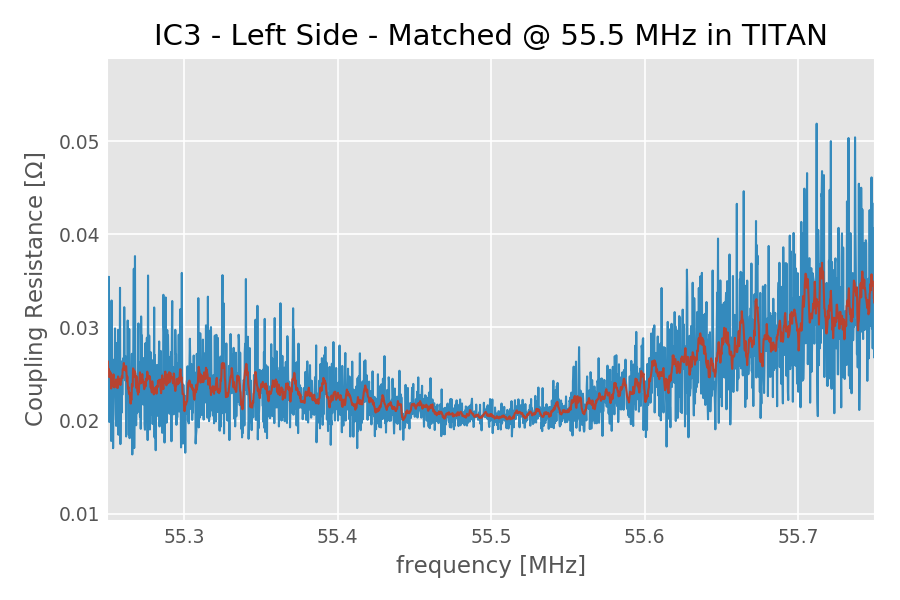

In [22]:
fig, ax = plt.subplots()
ax.plot(left.f/1e6, R[:,0])
ax.plot(left.f/1e6, rf.smooth(R[:,0]))
ax.set_ylabel('Coupling Resistance [$\Omega$]')
ax.set_xlabel('frequency [MHz]')
ax.set_title('IC3 - Left Side - Matched @ 55.5 MHz in TITAN', fontsize=14)

fig.tight_layout()
fig.savefig('IC3_Left_Matched55.5MHz_TITAN_Rc.png', dpi=150)

## Right side

In [23]:
right = rf.Network('Sparameters/IC3_Right_55p5MHz_TITAN_2.s4p', f_unit='MHz')
# excitation vector :
A = np.r_[0, 1, 0, 0]
# antenna response :
B = right.s @ A
Xs = calculate_Xs(right.f/1e6)

<IPython.core.display.Javascript object>


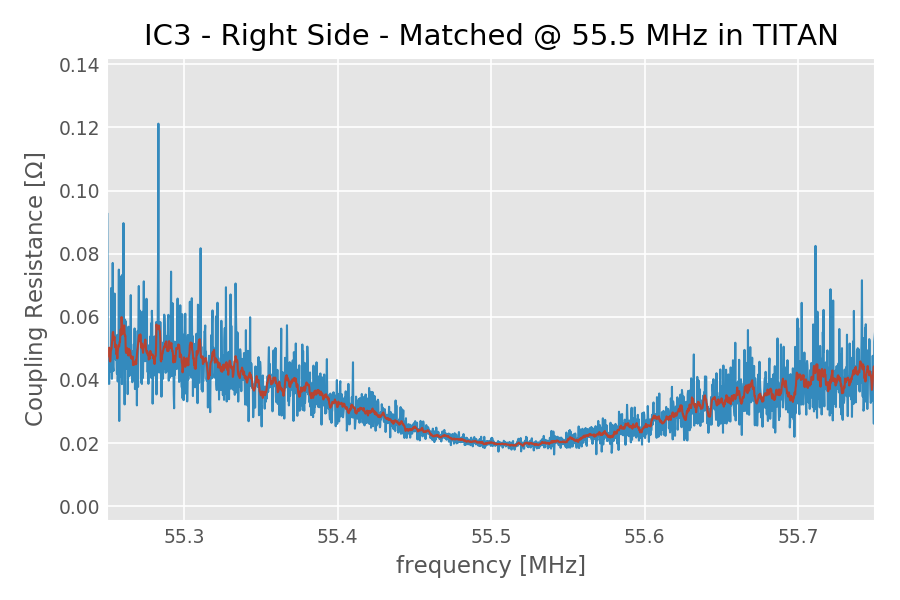

In [24]:
# frequency of interest
f0 = 55.5e6
# extrapolate vs frequency the probe trans coeff
Kv = np.tile(right.f/f0, (4,1)).T * np.transpose(10**(Kv_dB/20) * exp(-pi/2*1j))

V1 = Kv[:,0]*Kc[:,0]*sqrt(50)*B[:,2] # (S(3,1)*a1+S(3,2)*a2);
V2 = Kv[:,1]*Kc[:,1]*sqrt(50)*B[:,3] # (S(4,1)*a1+S(4,2)*a2);
V3 = Kv[:,2]*Kc[:,2]*sqrt(50)*B[:,2] # (S(3,1)*a1+S(3,2)*a2);
V4 = Kv[:,3]*Kc[:,3]*sqrt(50)*B[:,3] # (S(4,1)*a1+S(4,2)*a2);
V = np.c_[V1, V2, V3, V4]

P = 0.5*(abs(A[0:2])**2 - abs(B[:,0:2])**2)

VmL = sqrt((abs(V1)**2 + abs(V2)**2)/2)
VmR = sqrt((abs(V3)**2 + abs(V4)**2)/2)
RL  =  Xs**2 * P[:,0] / VmL**2
RR  =  Xs**2 * P[:,1] / VmR**2
R = np.c_[RL, RR]

fig, ax = plt.subplots()
ax.plot(right.f/1e6, R[:,1])
ax.plot(right.f/1e6, rf.smooth(R[:,1]))
ax.set_ylabel('Coupling Resistance [$\Omega$]')
ax.set_xlabel('frequency [MHz]')
ax.set_title('IC3 - Right Side - Matched @ 55.5 MHz in TITAN', fontsize=14)

fig.tight_layout()
fig.savefig('IC3_Right_Matched55.5MHz_TITAN_Rc.png', dpi=150)

# Error Adapter

In [25]:
# This is the chain matrix (ABCD) of the error box, Port 1 is 50ohm side, Port 2 is 30ohm 9inch side
error_adapter = loadmat('Error Adapter/T_errorbox.mat')
error_adapter

{'__header__': b'MATLAB 5.0 MAT-file, Platform: PCWIN64, Created on: Fri Jan 11 12:16:14 2019',
 '__version__': '1.0',
 '__globals__': [],
 'T11': array([[ 0.83816247-2.95942523e-10j,  0.84324803+0.00000000e+00j,
          0.84834366+3.59127990e-16j, ..., -0.14844734+2.92271134e-16j,
         -0.14844734+2.92271134e-16j, -0.14844734+2.92271134e-16j]]),
 'T12': array([[ 5.66741113e-09-30.79138879j,  0.00000000e+00-30.68287893j,
         -6.89525741e-15-30.57947027j, ..., -2.17926438e-15+39.10265269j,
         -2.17926438e-15+39.10265269j, -2.17926438e-15+39.10265269j]]),
 'T21': array([[ 7.52828755e-12-0.02025971j,  0.00000000e+00-0.02015499j,
         -4.48909987e-18-0.0200479j , ..., -7.09395956e-19+0.02504893j,
         -7.09395956e-19+0.02504893j, -7.09395956e-19+0.02504893j]]),
 'T22': array([[ 0.44880969-2.55087439e-10j,  0.4525203 -7.21382839e-17j,
          0.45611908+1.07738397e-16j, ..., -0.13823327+1.53229527e-16j,
         -0.13823327+1.53229527e-16j, -0.13823327+1.53229527e

In [26]:
# converting the ABCD matrix into skrf Network
A11 = error_adapter['T11'].squeeze()
A12 = error_adapter['T12'].squeeze()
A21 = error_adapter['T21'].squeeze()
A22 = error_adapter['T22'].squeeze()

# creating a (2,2) matrix for all the N frequencies (2,2,N)
# pays attention that A21 is volontary transposed with A12
# in order to be at the correct position after swaping the axes after
# (1st dimension in Numpy along rows!)
A = np.array([[A11, A21],
              [A12, A22]])
# (2,2,N) -> (N,2,2) 
A = A.swapaxes(2,0)

# transforming to S matrices
S = rf.network.a2s(A, z0=50)

# converting the transmission parameters to skrf Network
freq = rf.Frequency.from_f(error_adapter['fMHz'].squeeze(), unit='MHz')
err = rf.Network(s=S, frequency=freq, z0=50, name="error adapter")


<IPython.core.display.Javascript object>


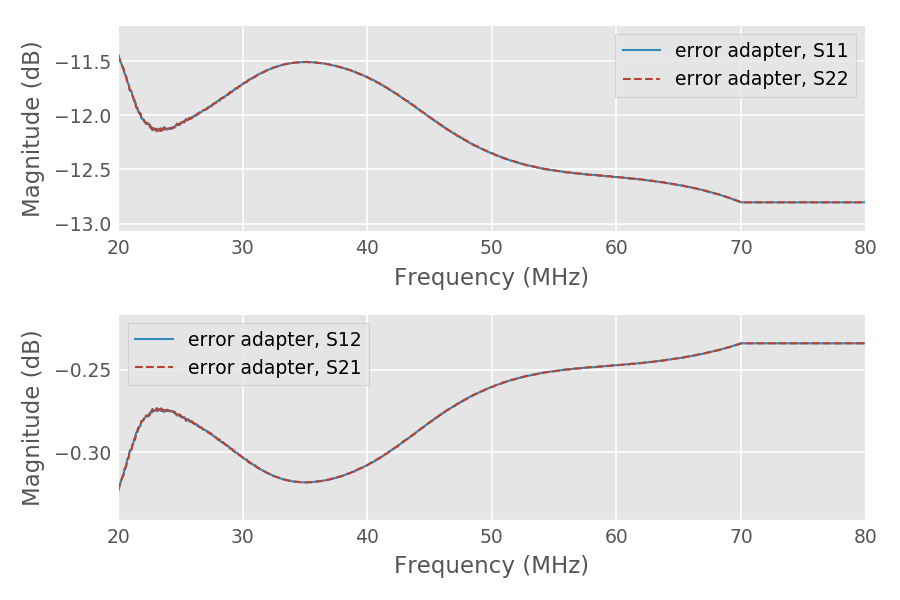

In [27]:
fig, axes = plt.subplots(2,1)
err.plot_s_db(ax=axes[0], m=0, n=0)
err.plot_s_db(ax=axes[0], m=1, n=1, ls='--')

err.plot_s_db(ax=axes[1], m=0, n=1)
err.plot_s_db(ax=axes[1], m=1, n=0, ls='--')
fig.tight_layout()

<IPython.core.display.Javascript object>


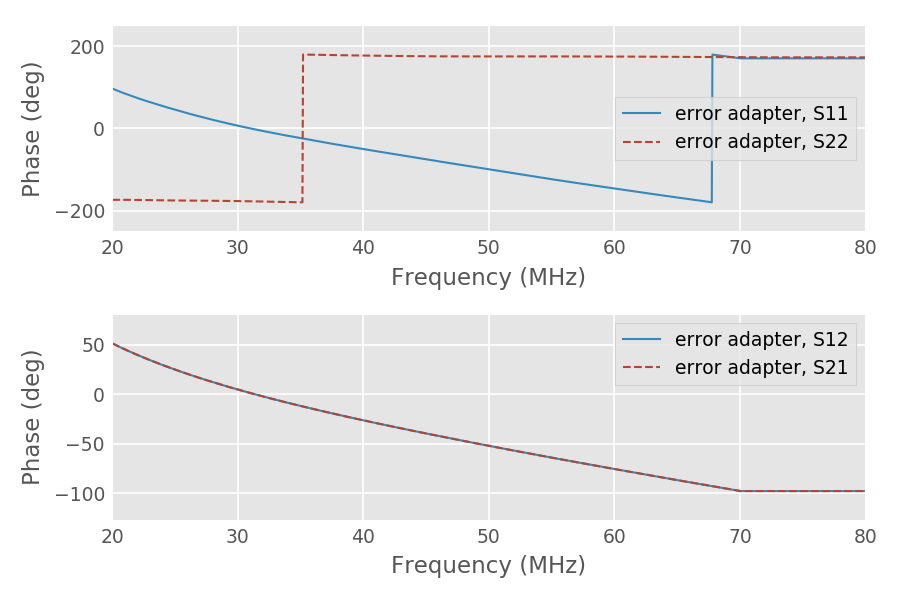

In [28]:
fig, axes = plt.subplots(2,1)
err.plot_s_deg(ax=axes[0], m=0, n=0)
err.plot_s_deg(ax=axes[0], m=1, n=1, ls='--')

err.plot_s_deg(ax=axes[1], m=0, n=1)
err.plot_s_deg(ax=axes[1], m=1, n=0, ls='--')
fig.tight_layout()